In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import jsonpickle

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
RUNDIR = "../output"
RUNID = "20240203_173457"

In [3]:
config_files = list(Path(RUNDIR).glob(f"{RUNID}*.config.json"))
print(f"Found {len(config_files)} config files")

Found 4 config files


In [4]:
configs = {}
dfs = {}
for config_file in config_files:
    config = jsonpickle.decode(config_file.read_text())
    data_file = Path(RUNDIR, config_file.name.split(".")[0] + ".csv")
    sub_id = config_file.name.split(".")[0].split("_")[-1]
    
    data = pd.read_csv(data_file)
    data["id"] = sub_id
    data["algorithm"] = config["algorithm"]
    data["dataset"] = config["dataset"]
    data["imbalance"] = config["imbalance_type"]
    data["imbalance_val"] = config["imbalance_value"]
    data["is_last_round"] = data["round"] == (config["rounds"] - 1)
    data
    
    if sub_id in configs:
        print("Duplicate id!")
    dfs[sub_id] = data
    configs[sub_id] = config
    
data = pd.concat(dfs.values(), axis=0)
data = data.query("variable != 'cluster_identities'")
data["value"] = data["value"].astype(float)

In [5]:
data["variable"].unique()

array(['loss', 'n_samples', 'f1'], dtype=object)

In [6]:
data = data.pivot_table(values = "value", index = ["round", "client", "stage", "id", "algorithm", "dataset", "imbalance", "imbalance_val", "is_last_round"], columns = ["variable"]).reset_index()
data.head()

variable,round,client,stage,id,algorithm,dataset,imbalance,imbalance_val,is_last_round,f1,loss,n_samples
0,0,0,test,1,IFCA,mnist,label_distribution,0.1,False,0.803500,0.611626,678.0
1,0,0,test,3,FLSC,mnist,label_distribution,0.1,False,0.803500,2.024788,678.0
2,0,0,train,1,IFCA,mnist,label_distribution,0.1,False,NaN,1.041409,678.0
3,0,0,train,3,FLSC,mnist,label_distribution,0.1,False,NaN,2.138137,678.0
4,0,1,test,1,IFCA,mnist,label_distribution,0.1,False,0.545429,1.073373,460.0


<Axes: xlabel='round', ylabel='loss'>

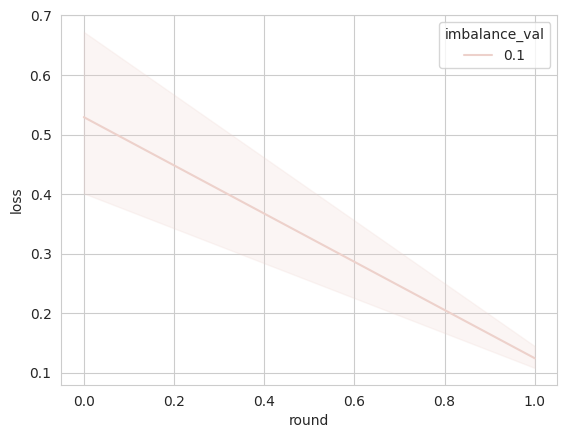

In [7]:
df = data.query("stage == 'train' and algorithm == 'IFCA'")
sns.lineplot(df, x = "round", y = "loss", hue = "imbalance_val")

<Axes: xlabel='round', ylabel='f1'>

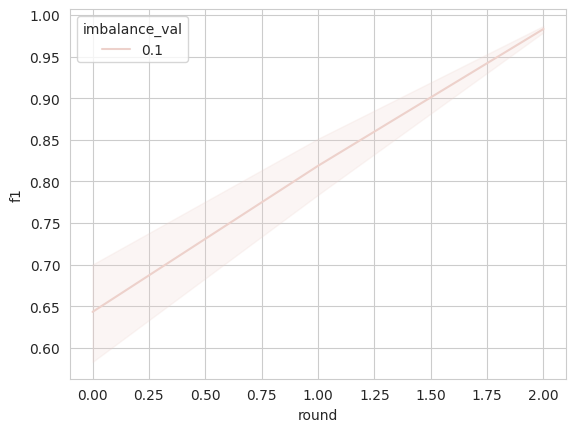

In [8]:
df = data.query("stage == 'test'")
sns.lineplot(df, x = "round", y = "f1", hue = "imbalance_val")

In [9]:
df_last = data.query("stage == 'test' and is_last_round")
df_last.head()

variable,round,client,stage,id,algorithm,dataset,imbalance,imbalance_val,is_last_round,f1,loss,n_samples
320,1,0,test,0,FedAvg,mnist,label_distribution,0.1,True,0.803500,0.565984,678.0
321,1,0,test,3,FLSC,mnist,label_distribution,0.1,True,0.061467,2.135337,678.0
324,1,1,test,0,FedAvg,mnist,label_distribution,0.1,True,0.545429,0.869336,460.0
325,1,1,test,1,IFCA,mnist,label_distribution,0.1,True,0.992141,0.039532,460.0
326,1,1,test,3,FLSC,mnist,label_distribution,0.1,True,0.550904,1.962810,460.0


Text(0.5, 1.0, 'Avg. F1 scores by imbalance param')

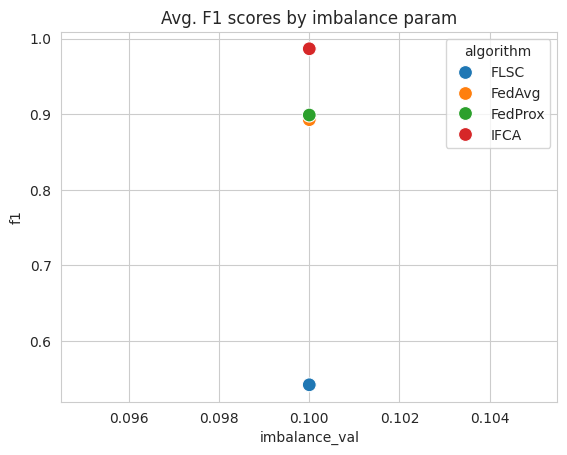

In [10]:
df_last_avg = df_last.groupby(["imbalance", "imbalance_val", "algorithm"]).mean(["f1", "loss"]).reset_index()\
    .query("imbalance == 'label_distribution'")
sns.scatterplot(df_last_avg, x="imbalance_val", y="f1", hue='algorithm', s=100)
plt.title("Avg. F1 scores by imbalance param")

In [11]:
local = df_last.query("algorithm == 'Local'")[["client","imbalance","imbalance_val","f1"]]
fedavg = df_last.query("algorithm == 'FedAvg'")[["client","imbalance","imbalance_val","f1"]]
fedprox = df_last.query("algorithm == 'fedprox'")[["client","imbalance","imbalance_val","f1"]]
ifca = df_last.query("algorithm == 'IFCA'")[["client","imbalance","imbalance_val","f1"]]
flsc = df_last.query("algorithm == 'FLSC'")[["client","imbalance","imbalance_val","f1"]]

In [12]:
f1scores = ifca.merge(flsc, on=["client", "imbalance", "imbalance_val"], suffixes=["_ifca", "_flsc"])\
    .merge(fedavg, on=["client", "imbalance", "imbalance_val"])\
    .merge(local, on=["client", "imbalance", "imbalance_val"], suffixes=["_fedavg", "_local"])
f1scores = f1scores.query("imbalance == 'label_distribution'")
f1scores

variable,client,imbalance,imbalance_val,f1_ifca,f1_flsc,f1_fedavg,f1_local


In [13]:
f1scores["benefit_fedavg"] = f1scores["f1_fedavg"] - f1scores["f1_local"]
# f1scores["benefit_fedprox"] = f1scores["f1_fedprox"] - f1scores["f1_local"]
f1scores["benefit_ifca"] = f1scores["f1_ifca"] - f1scores["f1_local"]
f1scores["benefit_flsc"] = f1scores["f1_flsc"] - f1scores["f1_local"]

In [14]:
benefits = f1scores.drop(columns=["f1_local", "f1_fedavg", "f1_ifca", "f1_flsc"]).melt(id_vars=["client", "imbalance", "imbalance_val"], value_name="client_benefit", var_name="algorithm")

In [15]:
avg_benefits = benefits.groupby(["imbalance", "imbalance_val", "algorithm"]).mean().reset_index()

In [16]:
sns.scatterplot(avg_benefits, x="imbalance_val", y="benefit", hue="algorithm")

ValueError: Could not interpret value `benefit` for `y`. An entry with this name does not appear in `data`.